# Cov-SSI on shear frame (precomputed data)

In [1]:
import koma.oma, koma.plot

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend, welch, resample

import matplotlib.pyplot as plt

%matplotlib qt

c:\users\knutankv\git-repos\koma\koma\plot.py:772: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if renderer is 'default':


In [3]:
# Convenience functions
def plot_mode(ax, phi, scaling=1.0):
    levels = len(phi)
    phi_plot = np.hstack([0, phi])
    
    if scaling is not None:
        maxval = np.max(np.abs(np.real(phi_plot)))
        phi_plot = phi_plot/maxval * scaling

    handle = [None]*(levels+2)
    
    handle[0] = ax.plot(phi_plot-0.5, np.arange(levels+1), color='black')[0]
    handle[1] = ax.plot(phi_plot+0.5, np.arange(levels+1), color='black')[0]
    
    for level in range(levels):
        handle[level+2] = ax.plot([phi_plot[level+1]-0.5, phi_plot[level+1]+0.5], [level+1, level+1], color='black')[0]

    return handle

def plot_all_modes(levels, phi, phi_ref):
    # Mode shapes: simple plots
    fig, ax = plt.subplots(ncols=levels, nrows=1, sharey=True)
    for n in range(phi.shape[1]):
        max_true = np.argmax(np.abs(phi[:, n]))
        flip_factor = np.real(np.sign(phi[max_true, n]/phi_ref[max_true, n]))

        h2 = plot_mode(ax[n], phi_ref[:, n]*flip_factor)
        __ = [hi.set(alpha=1.0, color='gray', linestyle='-') for hi in h2]
        h1 = plot_mode(ax[n], phi[:, n])
        __ = [hi.set(alpha=1.0, color='red', linestyle='--') for hi in h1]

        ax[n].set_title(f'Mode {n+1}')
        
    ax[0].set_ylabel('Level')
    return fig, ax

## Load data and define reference solution

In [5]:
data = np.load('./data/data_shearframe.npy')
fs = 12.0
tmax = 1200
t = np.arange(0, tmax, 1/fs)
levels = data.shape[1] #number of channels

# Load reference modal properties
omega_n_ref = np.load('./data/omega_n.npy')
xi_ref = np.load('./data/xi_ref.npy')
phi_ref = np.load('./data/phi_ref.npy')

## Plot data

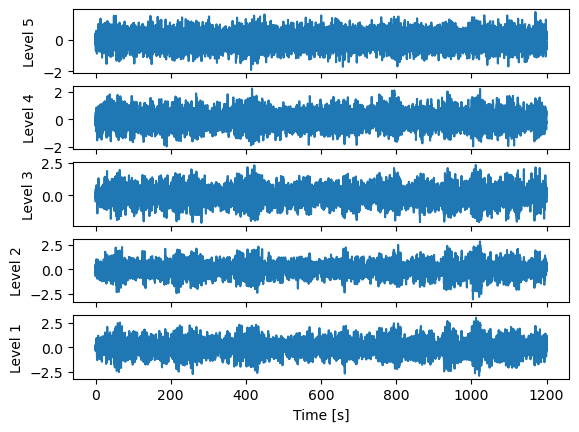

In [7]:
fig, ax = plt.subplots(nrows=levels, ncols=1, num=1, sharex =True)

for level, axi in enumerate(ax[::-1]):    
    axi.plot(t, data[:,level])
    axi.set_ylabel(f'Level {level+1}')

__ = ax[-1].set_xlabel('Time [s]')
display(fig)

## Define SSI parameters

In [9]:
# Cov-SSI parameters
i = 50
orders_input = np.arange(2, 60+2, 2)

# Stabilization analysis parameters
stabcrit = {'freq':0.05, 'damping': 0.2, 'mac': 0.1}
s = 1
valid_range = {'freq': [0, np.inf], 'damping':[0, 0.3], 'mpc': [0.4, 1]}

## Cov-SSI call and stabilization

In [11]:
lambd, phi, orders = koma.oma.covssi(data, fs, i, orders_input) # find poles by Cov-SSI
lambd_stab, phi_stab, orders_stab, ix_stab = koma.oma.find_stable_poles(lambd, phi, orders, s, 
                                                                        stabcrit=stabcrit, valid_range=valid_range, 
                                                                        indicator='freq') # Stable poles

*** Covariance-driven SSI algorithm for OMA ***
> Establishing Hankel/Toeplitz matrices
  >> Correlation estimation
  >> Matrix stacking
> Establishing weighting matrices
  >> Weighting requested: NONE
> Computing SVD
> Computing state matrix for each order to establish modes
> Computation completed


## Welch PSD estimate

In [13]:
nperseg = 1024
zp = 4
nfft = nperseg*zp

f, Pxx = welch(data[:,0], fs, 'hann', nperseg=nperseg, nfft=nfft)


## Visualization: stabilization plot

In [15]:
# fig = koma.plot.stabplot(lambd_stab, orders_stab, psd_freq=f*2*np.pi, psd_y=Pxx/np.pi/2, 
#                          frequency_unit='rad/s', freq_range=[0,np.max(omega_n_ref)*1.2], 
#                          damped_freq=False)
# fig

### Recommended approach (matplotlib-based)

In [15]:
%matplotlib qt
stab_plotter = koma.plot.StabPlotter(lambd_stab, orders_stab, phi=phi_stab, freq_unit='hz', 
                                     damped_freq=False, annotate_hover=True, psd_freq=f, psd_y=Pxx, log_psd_scale=True)
fig = stab_plotter.get_fig()
phi_sel, fn_sel, xi_sel = stab_plotter.phi, stab_plotter.fn, stab_plotter.xi
df = stab_plotter.get_df()

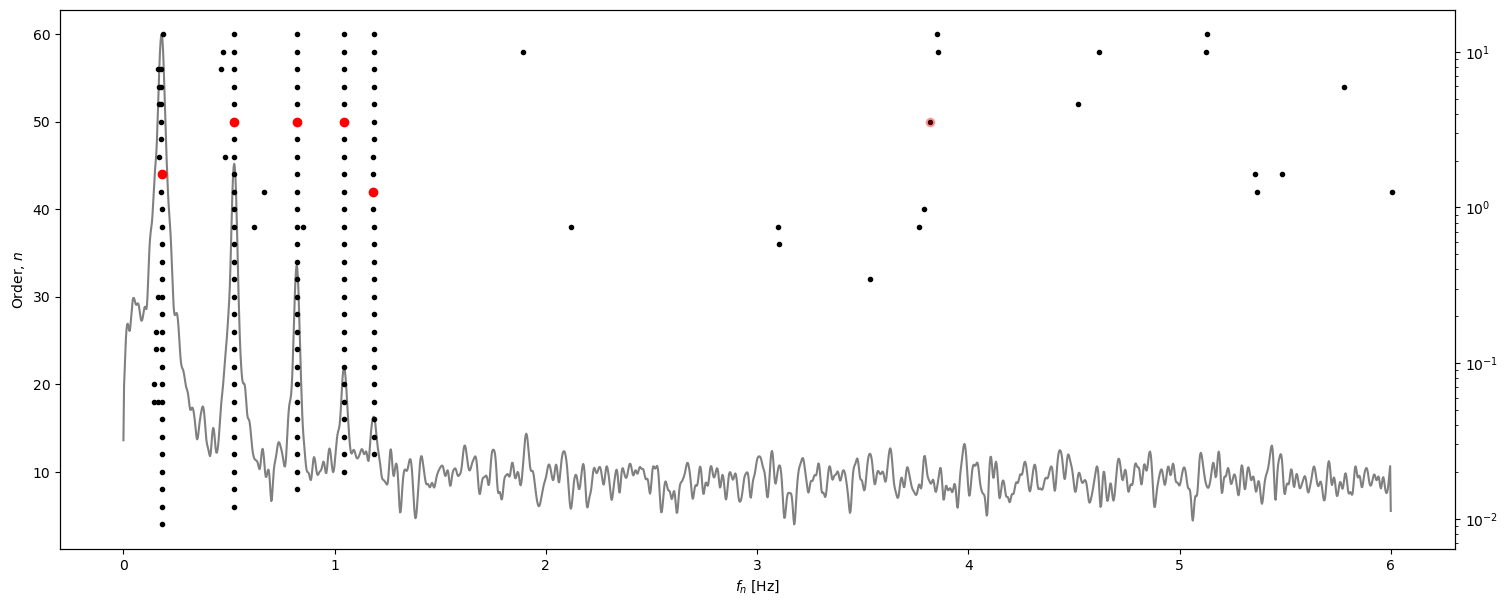

,ix,n_picked,wn,xi
0,107,44,1.133278,0.056412
1,126,50,3.296884,0.012287
2,127,50,5.149427,0.009701
3,128,50,6.555918,0.007207
4,104,42,7.438206,0.008087


In [17]:
# Display results
display(fig)
display(df)

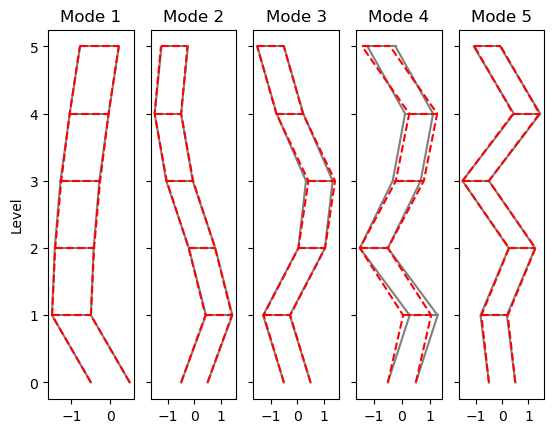

In [19]:
fig, ax = plot_all_modes(levels, np.real(phi_ref), np.real(phi_sel))
display(fig)